In [1]:
%matplotlib notebook

import math
from typing import List, Union

import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display

import pymapmanager as pmm

## Load a stack and annotations using PyMapManager API

In [4]:
stackPath = '../../PyMapManager-Data/one-timepoint/rr30a_s0_ch2.tif'
myStack = pmm.stack(stackPath)
print(myStack)

   INFO - [stack()] stack.py loadImages() line:254 -- Loaded tif data (70, 1024, 1024) from tif file: ../../PyMapManager-Data/one-timepoint/rr30a_s0_ch1.tif
   INFO - [stack()] stack.py loadHeader() line:213 -- Loading header ../../PyMapManager-Data/one-timepoint/rr30a_s0/rr30a_s0.json
   INFO - [baseAnnotations()] baseAnnotations.py load() line:800 -- loading file:../../PyMapManager-Data/one-timepoint/rr30a_s0/rr30a_s0_pa.txt
   INFO - [baseAnnotations()] baseAnnotations.py load() line:850 --   loaded df: rows: 287 cols 13
   INFO - [baseAnnotations()] baseAnnotations.py load() line:800 -- loading file:../../PyMapManager-Data/one-timepoint/rr30a_s0/rr30a_s0_la.txt
   INFO - [baseAnnotations()] baseAnnotations.py load() line:850 --   loaded df: rows: 2121 cols 13
stack base name: rr30a_s0 channels: 2 slices: 70 rows: 1024 columns: 1024 annotations: 287 segments: 5


## I am defining some functions to make life easier

Try and move these kinds of functions into the backend. Into out annotation classes. The goal should be to make a notebook like this super simple to understand, use, and extend.

In [2]:
def _getSegment(lineAnnotations : pmm.annotations.lineAnnotations, segmentID : int) -> pd.DataFrame:
    """Get all annotations rows for one segment id.
    """
    dfLines = lineAnnotations._df  # All of our annotation classes are represented as a dataframe (_df)
    dfOneSegment = dfLines[dfLines['roiType']=='linePnt']
    dfOneSegment = dfOneSegment[dfLines['segmentID']==segmentID]
    return dfOneSegment

def _getSegmentList(lineAnnotations : pmm.annotations.lineAnnotations) -> List[int]:
    """Get a list of all segment ID.
    """
    return lineAnnotations.getDataFrame()['segmentID'].to_numpy()

def _getSegmentSpines(pointAnnotations : pmm.annotations.pointAnnotations, segmentID : int) -> pd.DataFrame:
    """Get all spines connected to one segment.
    """
    dfPoints = pointAnnotations.getDataFrame()
    dfSpines = dfPoints[dfPoints['roiType'] == 'spineROI']
    dfSpines = dfSpines[dfSpines['segmentID']==segmentID]
    return dfSpines

def _getOneSpine(pointAnnotations : pmm.annotations.pointAnnotations, rowIndex : int):
    """Get one spine as a pd.DataFrame.
    """""
    dfPoints = pointAnnotations.getDataFrame()
    return dfPoints.loc[rowIndex]


## Plot a spine, the z-image it lives in and the entire segment line

In [3]:

def plotOneSpine(theStack, channel, spineIndex):
    """Given a spine index
        Plot that spine (in yellow)
        Plot the image corresponding to the Z-plane of given spine
        Plot all other spines on the same segment
        Plot the line for that segment
    """
    # pull one spine from point annotations
    pointAnnotations = theStack.getPointAnnotations()
    dfOneSpine = _getOneSpine(pointAnnotations, oneSpineIndex)

    # the spine we pulled tells us the segment(ID) it belongs to
    segment = dfOneSpine['segmentID']

    # what we will plot (spine)
    xOneSpine = dfOneSpine['x']
    yOneSpine = dfOneSpine['y']
    zOneSpine = dfOneSpine['z']

    # all spines on the segment
    dfAllSpines = _getSegmentSpines(pointAnnotations, segmentID=segment)

    #
    # pull the line segment from line annotations
    lineAnnotations = theStack.getLineAnnotations()
    dfOneSegmentLine = _getSegment(lineAnnotations, segmentID=segment)

    # what we will plot (segment)
    xOneSegment = dfOneSegmentLine['x']
    yOneSegment = dfOneSegmentLine['y']
    zOneSegment = dfOneSegmentLine['z']

    # load the image stack
    # images are not loaded by default (saves time and memory when not needed)
    # TODO: check if loadImages() is loading every time we run this. It should not.
    #    yes, load images is not smart enough, it loads every time loadImages() is called
    #    instead, it should check if already loaded and not load again (saves time and is faster)
    #.   as always, we then want a parameter to loadImages() to say 'forceLoad' to over-ride this behavior
    #.   this is similar to what I have implemented in annotation save that keeps track of _dirty
    #.   and does not save annotations unless they are _dirty (modified) or passed 'forceSave'.
    myStack.loadImages(channel=channel)

    # grab one image slice to plot
    # TODO: add check for int imageSlice in the stack.getImageSlice backend, convert if necc.
    zOneSpine = int(zOneSpine)  # special case because we will use it as slice, it needs to be int for numpy indexing
    ch2_img = myStack.getImageSlice(imageSlice=zOneSpine, channel=channel)

    #
    # plot the image
    plt.imshow(ch2_img)
    # plot all spines on the segment, will plot spines outside of image (zOneImage)
    plt.plot(dfAllSpines['x'], dfAllSpines['y'], 'or')
    # plot one spine (yellow)
    plt.plot(xOneSpine, yOneSpine, 'oy')
    # plot the segment, will plot parts of the segment outside of image (zOneImage)
    plt.plot(xOneSegment, yOneSegment, '.c')

    #plt.show()


## Use above function to plot one spine (With other stuff).

- Plot one spine (yellow),
- the z-image plane it lives in,
- all other spines (red) on its segment
- the line annotation for that spines segment (cyan).

   INFO - [stack()] stack.py loadImages() line:254 -- Loaded tif data (70, 1024, 1024) from tif file: ../../PyMapManager-Data/one-timepoint/rr30a_s0_ch2.tif


<IPython.core.display.Javascript object>


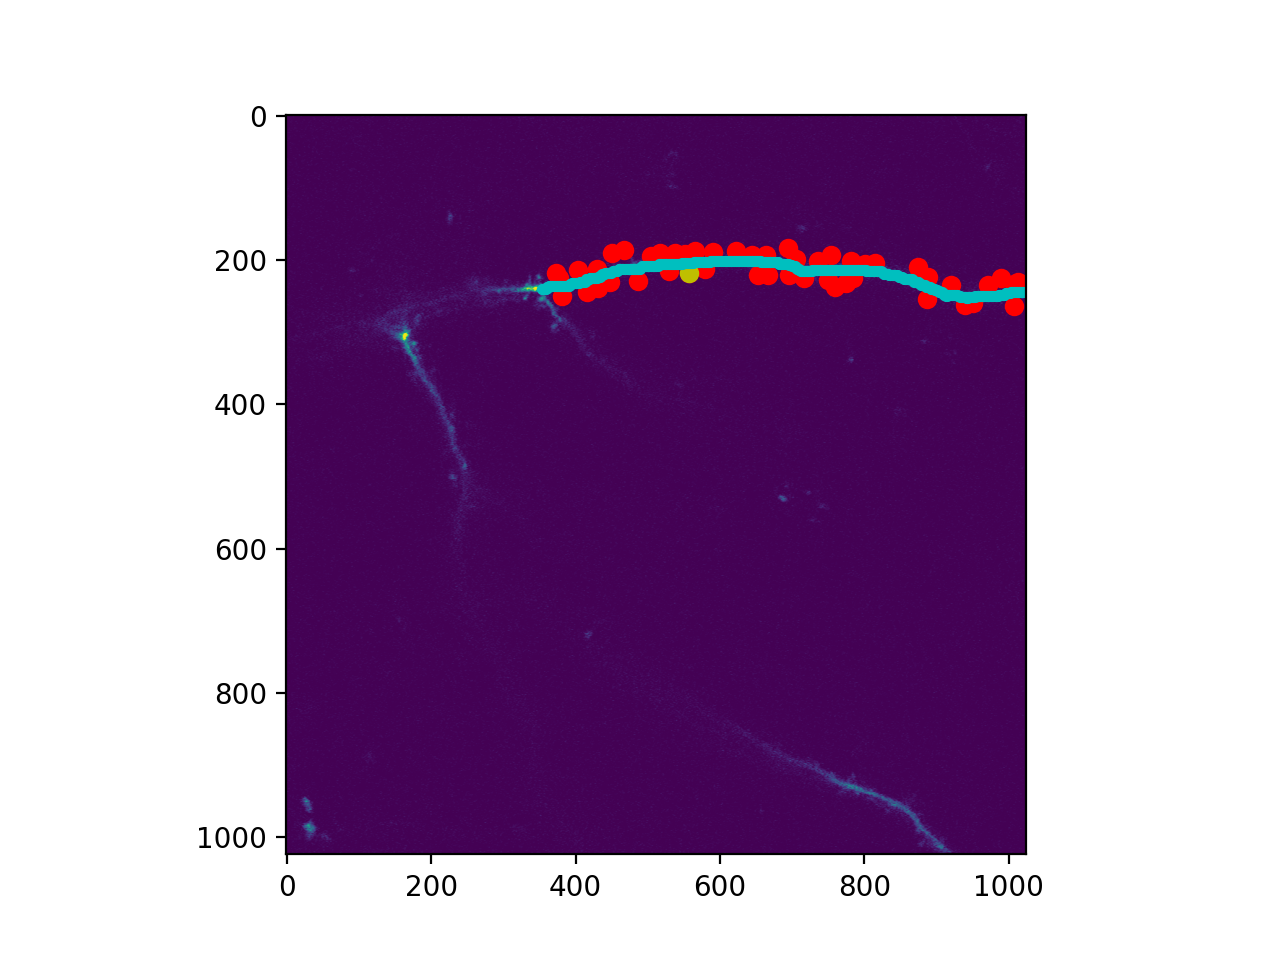

In [5]:
oneSpineIndex = 72  # one spineROI we will plot
channel = 2  # the image channel we will plot
plotOneSpine(myStack, channel, oneSpineIndex)

## Backend utility functions

Because these do not rely on any of our classes, they could go into a utils.py file?

 - Given a point (x,y,z) and a line, find closest point on line
 - Use that closest point as a seed and look +/- along the line for the brightest path


In [6]:
def _findClosestPoint(x, y, z, xyzLine : List[List[float]]) -> int:
    """Find the closest point to (x,y,z) on line.
    """
    dist = float('inf') # np.inf
    closestIdx = None
    for idx, point in enumerate(xyzLine):
        dx = abs(x - point[0])
        dy = abs(y - point[1])
        dz = abs(z - point[2])
        _dist = math.sqrt( dx**2 + dy**2 + dz**2)
        if _dist < dist:
            dist = _dist
            closestIdx = idx
    return closestIdx

def _findBrightestPath(x, y, z, xyzLine : List[List[float]]) -> int:
    """Find the brightest path in an image volume
        From one point (x,y,z) to the given candidates line (xyzLine).
    
        TODO: This function also needs an nparray of the image to search!
            Rather than a single image slice, pass it a small z-projection centered on z
            use pmm.stack.getMaxProjectSlice() to do this.
    """
    numPnts = 5  # parameter for the search, seach +/- from closest point (seed point)
    
    # 1) use pythagrian theorem to find the closest point on the line.
    #    This will be the seed point for searching for the brigtest path
    closestPoint = _findClosestPoint(x, y, z, xyzLine)
    
    # 2) grab a list of candidate points on the line
    #.   [xyzLine[closestPoint-numPnts:closestPoint+numPnts]]
    
    # 3) using intensity profile, find the point on the line with the brightest path (from the spine point)
    # See: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.profile_line
    
    # for now, just return the closest point
    return closestPoint


## For each segment, for each spine ... calculate the brightest path from spine to segment

For now, we only clculate the shortest distance bwteen spline and line. Still need to calculate the brightest path.

For now, when I zoom in and look at the plot, we have too many 'closest points'? E.g., more closest points than we have spines? Idk, not sure if this is true or is a bug in my code?

<IPython.core.display.Javascript object>


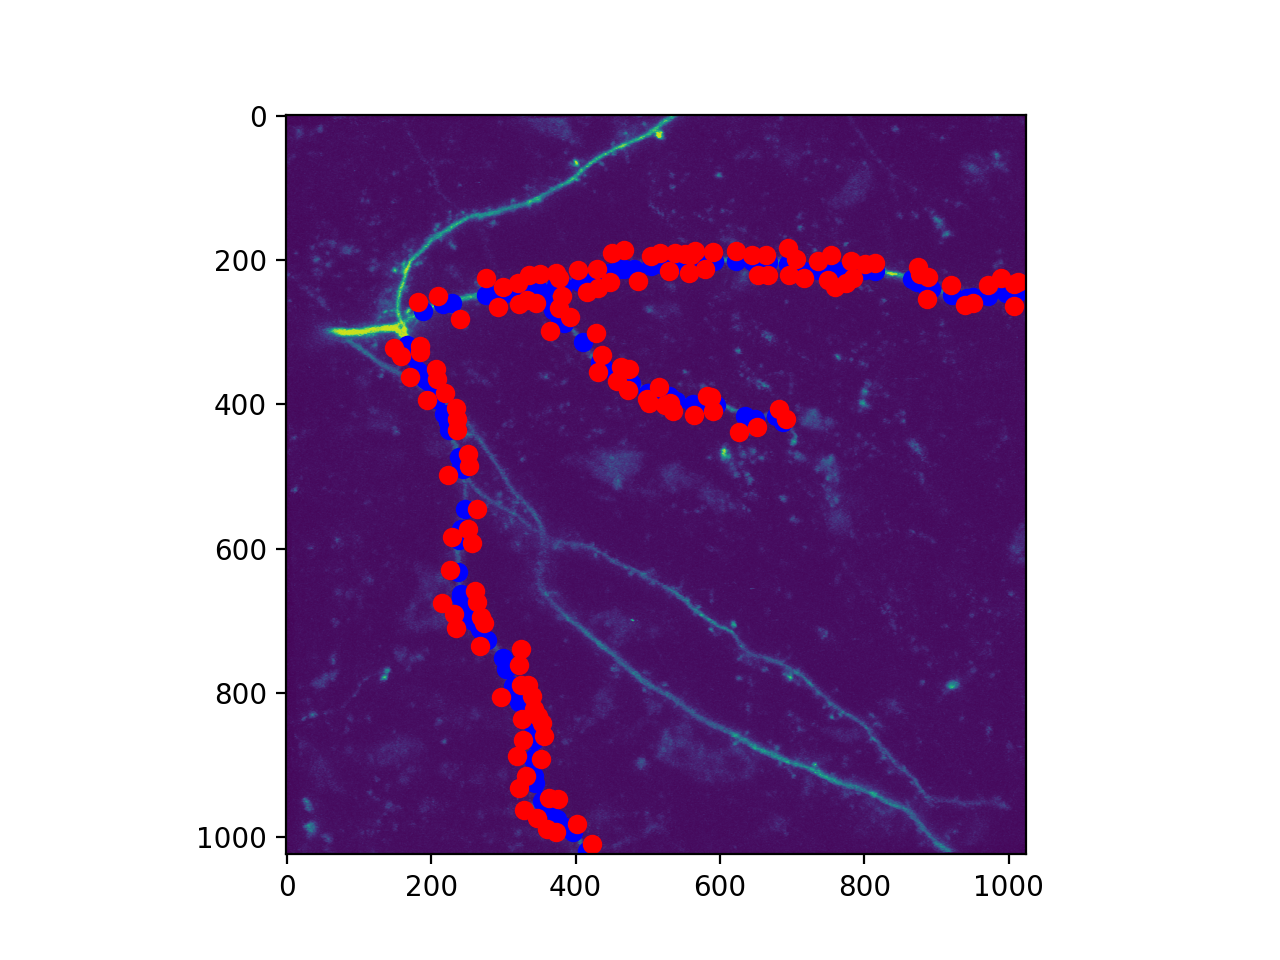

plotting


In [7]:
# plot the max project image
maxProjectImage = myStack.getMaxProject(channel=2)

# This is bad form and will lead to future headaches
# here I am mixing plotting with backend computation
# they should be done seperately and independently
# running the backend should never rely on detail of plotting
# we could be plotting in Jupyter, PyQt, web, etc...
fig, axs = plt.subplots(1, 1)
axs.imshow(maxProjectImage)

xyzSpines = []

# accumulate the closest points [[x,y,z]]
# the closest point on the segment line (for each spine)
closestPoints = []

pointAnnotations = myStack.getPointAnnotations()
lineAnnotations = myStack.getLineAnnotations()

segments = _getSegmentList(lineAnnotations)  # List[int] of segmentID in line tracing annotations

for segment in segments:
    
    # get the [[x,y,z]] of the line segment just once
    dfLineSegment = _getSegment(lineAnnotations, segment)
    lineSegment = dfLineSegment[['x', 'y', 'z']].to_numpy()
    
    # get the spines on the segment
    dfSegmentSpines = _getSegmentSpines(pointAnnotations, segment)
        
    for idx, spine in dfSegmentSpines.iterrows():
        
        # the point we will search from
        xSpine = spine['x']
        ySpine = spine['y']
        zSpine = spine['z']
        
        xyzSpines.append([xSpine, ySpine, zSpine])
        
        # grab the image to search in
        # pass this image to _findBrightestPath (need to add another parameter)
        #searchImage = myStack.getMaxProjectSlice( ...)
        
        brightestPoint = _findBrightestPath(xSpine, ySpine, zSpine, lineSegment)
        # because we are working on a short list of line segment points
        # corresponding to just one segment, we need to reverse lookup the actual index into
        # the main annotations database
        # I recently added 'index' to all annotations
        actualIdx = dfLineSegment.iloc[brightestPoint]['index']
        
        xClosest = dfLineSegment.loc[actualIdx]['x']
        yClosest = dfLineSegment.loc[actualIdx]['y']
        zClosest = dfLineSegment.loc[actualIdx]['z']
        oneClosestPoint = [xClosest, yClosest, zClosest]
        closestPoints.append(oneClosestPoint)
        
        #print(f"segment: {segment} spine: {spine['index']} brightestPoint:{brightestPoint} actualIdx:{actualIdx}")
    

# print(f'xyzSpines:{len(xyzSpines)}, closestPoints:{len(closestPoints)}')
    
#plot all the closest points
xPlotClosest = [_point[0] for _point in closestPoints]
yPlotClosest = [_point[1] for _point in closestPoints]
#zPlotClosest = [_point[2] for _point in closestPoints]  # not used here
axs.plot(xPlotClosest, yPlotClosest, 'ob')

xPlotSpine = [xyzOneSpine[0] for xyzOneSpine in xyzSpines]
yPlotSpine = [xyzOneSpine[1] for xyzOneSpine in xyzSpines]
axs.plot(xPlotSpine, yPlotSpine, 'or')

print('plotting')
plt.show()

## Have fun!!!